In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, ShuffleSplit
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb
import pickle
import time

In [2]:
# Importing the dataset
traindata = pd.read_csv("data/train.csv")
#testdata = pd.read_csv('data/test.csv')

In [3]:
traindata = traindata.dropna()
print(traindata.shape)

(404287, 6)


In [4]:
np.isnan(traindata.any())

id              False
qid1            False
qid2            False
question1       False
question2       False
is_duplicate    False
dtype: bool

In [5]:
traindata.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
labels = np.array(traindata["is_duplicate"])

In [7]:
filename1 = 'data/q1_word2vec.pkl'
filename2 = 'data/q2_word2vec.pkl'
q1_word2vec = pickle.load(open(filename1, 'rb'))
q2_word2vec = pickle.load(open(filename2, 'rb'))

In [8]:
q1_word2vec

array([[-0.08091219,  0.0077042 , -0.01682285, ...,  0.05525358,
         0.0247016 , -0.02719343],
       [-0.07508043,  0.07053458,  0.02010522, ..., -0.06404843,
         0.03878755,  0.05159354],
       [ 0.0393091 , -0.0183156 ,  0.03425997, ..., -0.03147688,
        -0.08700491, -0.0594486 ],
       ...,
       [-0.00126756,  0.00785884,  0.00709831, ...,  0.00735182,
         0.02557292, -0.00076251],
       [-0.01940245, -0.00145773,  0.03575385, ..., -0.0498339 ,
         0.01454336, -0.06419364],
       [ 0.0253418 ,  0.00810537,  0.02050422, ..., -0.04502985,
        -0.0505335 ,  0.09045997]])

In [9]:
q2_word2vec

array([[-0.06372326,  0.01629744, -0.01969495, ...,  0.07126812,
         0.03986768, -0.01777058],
       [-0.06822676,  0.06621239,  0.03532542, ..., -0.05280603,
         0.04836475, -0.01148304],
       [ 0.04768634,  0.00320106, -0.03163398, ...,  0.00372084,
        -0.11316679, -0.03433291],
       ...,
       [-0.01541002,  0.05360006, -0.03930671, ...,  0.01347446,
         0.02799114, -0.00032104],
       [ 0.03830399,  0.06639467,  0.0484686 , ...,  0.02513547,
        -0.01287625,  0.00778557],
       [ 0.0253418 ,  0.00810537,  0.02050422, ..., -0.04502985,
        -0.0505335 ,  0.09045997]])

In [10]:
scaler = MinMaxScaler()

In [11]:
q1_word2vec = scaler.fit_transform(q1_word2vec)
q2_word2vec = scaler.fit_transform(q2_word2vec)

In [12]:
q1_word2vec

array([[0.33415072, 0.5194195 , 0.49756676, ..., 0.64465215, 0.55599942,
        0.37736184],
       [0.34742271, 0.67586402, 0.57937966, ..., 0.38597681, 0.5878326 ,
        0.56366884],
       [0.60775204, 0.45463148, 0.61073903, ..., 0.45659974, 0.3035512 ,
        0.30108826],
       ...,
       [0.5154071 , 0.51980455, 0.55056328, ..., 0.54078966, 0.55796855,
        0.43986284],
       [0.47413545, 0.49660675, 0.61404866, ..., 0.41679732, 0.53304258,
        0.28986771],
       [0.57596505, 0.5204184 , 0.58026363, ..., 0.42721365, 0.38597382,
        0.655576  ]])

In [13]:
q2_word2vec

array([[0.38647981, 0.54705929, 0.49635314, ..., 0.67289246, 0.58272415,
        0.4243963 ],
       [0.37757134, 0.66907479, 0.61952678, ..., 0.38652093, 0.60247249,
        0.43873721],
       [0.60686137, 0.5150456 , 0.46962533, ..., 0.51698877, 0.2270512 ,
        0.38662018],
       ...,
       [0.4820492 , 0.63824435, 0.45244845, ..., 0.53950079, 0.55512147,
        0.46419599],
       [0.58830196, 0.66952037, 0.64895031, ..., 0.5664152 , 0.46014009,
        0.48268593],
       [0.56266119, 0.52703404, 0.58634668, ..., 0.40446889, 0.3726195 ,
        0.67125343]])

In [14]:
q1_word2vec = np.nan_to_num(q1_word2vec)

In [15]:
q2_word2vec = np.nan_to_num(q2_word2vec)

In [16]:
features = np.hstack((q1_word2vec, q2_word2vec))

In [17]:
features

array([[0.33415072, 0.5194195 , 0.49756676, ..., 0.67289246, 0.58272415,
        0.4243963 ],
       [0.34742271, 0.67586402, 0.57937966, ..., 0.38652093, 0.60247249,
        0.43873721],
       [0.60775204, 0.45463148, 0.61073903, ..., 0.51698877, 0.2270512 ,
        0.38662018],
       ...,
       [0.5154071 , 0.51980455, 0.55056328, ..., 0.53950079, 0.55512147,
        0.46419599],
       [0.47413545, 0.49660675, 0.61404866, ..., 0.5664152 , 0.46014009,
        0.48268593],
       [0.57596505, 0.5204184 , 0.58026363, ..., 0.40446889, 0.3726195 ,
        0.67125343]])

Since the dataset is imbalanced, we did oversample by sampling from the minority class.

In [18]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_data, y_data = oversample.fit_resample(features, labels)

In [19]:
print(np.count_nonzero(y_data == 0))
print(np.count_nonzero(y_data == 1))

255024
255024


Now we have 510048 data points. 255024 from each class.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Models Training

## Support Vector Classifier (SVM Classifier)

In [21]:
splits = ShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

In [22]:
svc_param_grid = {'C':[1e-2, 1e-1, 1e0, 1e1, 1e2]}

In [23]:
svc_clf = LinearSVC(penalty='l2', loss='squared_hinge', dual=False, max_iter=3000)

In [24]:
svc_clf_search = HalvingGridSearchCV(svc_clf, svc_param_grid, cv=splits, factor=2, scoring='accuracy', verbose=3)

In [25]:
svc_clf_search.fit(X_train, y_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 102009
max_resources_: 408038
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 5
n_resources: 102009
Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV 1/1] END .........................................C=0.01; total time=  15.8s
[CV 1/1] END ..........................................C=0.1; total time=  14.0s
[CV 1/1] END ..........................................C=1.0; total time=  17.5s
[CV 1/1] END .........................................C=10.0; total time=  17.2s
[CV 1/1] END ........................................C=100.0; total time=  17.1s
----------
iter: 1
n_candidates: 3
n_resources: 204018
Fitting 1 folds for each of 3 candidates, totalling 3 fits
[CV 1/1] END ..........................................C=1.0; total time=  35.0s
[CV 1/1] END ..........................................C=0.1; total time=  34.7s
[CV 1/1] END ........................................

HalvingGridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=42, test_size=0.3, train_size=None),
                    estimator=LinearSVC(dual=False, max_iter=3000), factor=2,
                    param_grid={'C': [0.01, 0.1, 1.0, 10.0, 100.0]},
                    refit=<function _refit_callable at 0x000002419CDB38B0>,
                    scoring='accuracy', verbose=3)

In [26]:
svc_clf_search.best_params_

{'C': 0.01}

In [27]:
svc_clf_search.best_score_

0.6604063360318926

In [28]:
svc_clf_model = svc_clf_search.best_estimator_

In [29]:
svc_clf_model

LinearSVC(C=0.01, dual=False, max_iter=3000)

In [30]:
svc_calibrated = CalibratedClassifierCV(base_estimator=svc_clf_model, method="sigmoid", cv=splits)

In [31]:
svc_calibrated.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=LinearSVC(C=0.01, dual=False,
                                                max_iter=3000),
                       cv=ShuffleSplit(n_splits=1, random_state=42, test_size=0.3, train_size=None))

### Evaluation

Accuracy:  0.6589648073718263
Precision:  0.660956939691833
Recall:  0.6543944853517155
F1:  0.6576593420651243
ROC AUC:  0.6589701002112875
              precision    recall  f1-score   support

           0       0.66      0.66      0.66     50946
           1       0.66      0.65      0.66     51064

    accuracy                           0.66    102010
   macro avg       0.66      0.66      0.66    102010
weighted avg       0.66      0.66      0.66    102010



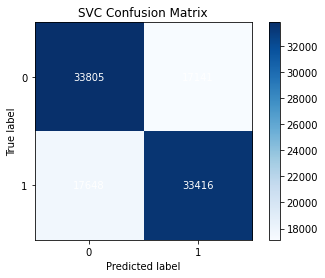

In [32]:
y_pred = svc_calibrated.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred))
print("ROC AUC: ", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.title('SVC Confusion Matrix')
plt.savefig('graphs/svc_fs4/svc_confusion_matrix.png')

## Logistic Regression

In [33]:
lr_param_grid = {'C':[1e-2, 1e-1, 1e0, 1e1, 1e2]}

In [34]:
lr_clf = LogisticRegression(penalty='l2', class_weight='balanced', dual=False, max_iter=3000)

In [35]:
lr_clf_search = HalvingGridSearchCV(lr_clf, lr_param_grid, cv=splits, factor=2, scoring='accuracy', verbose=3)

In [36]:
lr_clf_search.fit(X_train, y_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 102009
max_resources_: 408038
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 5
n_resources: 102009
Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV 1/1] END .........................................C=0.01; total time=   6.0s
[CV 1/1] END ..........................................C=0.1; total time=   9.5s
[CV 1/1] END ..........................................C=1.0; total time=  16.5s
[CV 1/1] END .........................................C=10.0; total time=  13.9s
[CV 1/1] END ........................................C=100.0; total time=  12.6s
----------
iter: 1
n_candidates: 3
n_resources: 204018
Fitting 1 folds for each of 3 candidates, totalling 3 fits
[CV 1/1] END .........................................C=10.0; total time=  27.6s
[CV 1/1] END ........................................C=100.0; total time=  20.2s
[CV 1/1] END ........................................

HalvingGridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=42, test_size=0.3, train_size=None),
                    estimator=LogisticRegression(class_weight='balanced',
                                                 max_iter=3000),
                    factor=2, param_grid={'C': [0.01, 0.1, 1.0, 10.0, 100.0]},
                    refit=<function _refit_callable at 0x000002419CDB38B0>,
                    scoring='accuracy', verbose=3)

In [37]:
lr_clf_search.best_params_

{'C': 0.1}

In [38]:
lr_clf_search.best_score_

0.6601285832155607

In [39]:
lr_clf_model = lr_clf_search.best_estimator_

In [40]:
lr_clf_model

LogisticRegression(C=0.1, class_weight='balanced', max_iter=3000)

### Evaluation

Accuracy:  0.6584256445446525
Precision:  0.6614765848996496
Recall:  0.6505953313488955
F1:  0.6559908380064765
ROC AUC:  0.6584347127438939
              precision    recall  f1-score   support

           0       0.66      0.67      0.66     50946
           1       0.66      0.65      0.66     51064

    accuracy                           0.66    102010
   macro avg       0.66      0.66      0.66    102010
weighted avg       0.66      0.66      0.66    102010



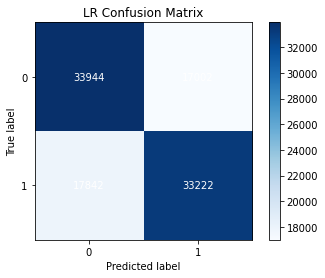

In [41]:
y_pred = lr_clf_model.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred))
print("ROC AUC: ", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.title('LR Confusion Matrix')
plt.savefig('graphs/lr_fs4/lr_confusion_matrix.png')

## Random Forest Classifier

In [42]:
rf_param_grid = {
                    'n_estimators':[200, 500, 800], 
                    'min_samples_split':[5, 15],
                    'max_depth': [70, 150, None]
                }

In [43]:
rf_clf = RandomForestClassifier()

In [44]:
rf_clf_search = HalvingGridSearchCV(rf_clf, rf_param_grid, cv=splits, factor=2, scoring='accuracy', verbose=3)

In [45]:
rf_clf_search.fit(X_train, y_train)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 25502
max_resources_: 408038
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 18
n_resources: 25502
Fitting 1 folds for each of 18 candidates, totalling 18 fits
[CV 1/1] END max_depth=70, min_samples_split=5, n_estimators=200; total time= 1.3min
[CV 1/1] END max_depth=70, min_samples_split=5, n_estimators=500; total time= 3.2min
[CV 1/1] END max_depth=70, min_samples_split=5, n_estimators=800; total time= 5.2min
[CV 1/1] END max_depth=70, min_samples_split=15, n_estimators=200; total time= 1.3min
[CV 1/1] END max_depth=70, min_samples_split=15, n_estimators=500; total time= 3.2min
[CV 1/1] END max_depth=70, min_samples_split=15, n_estimators=800; total time= 5.1min
[CV 1/1] END max_depth=150, min_samples_split=5, n_estimators=200; total time= 1.3min
[CV 1/1] END max_depth=150, min_samples_split=5, n_estimators=500; total time= 3.5min
[CV 1/1] END max_depth=150, min_samples_split=5,

HalvingGridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=42, test_size=0.3, train_size=None),
                    estimator=RandomForestClassifier(), factor=2,
                    param_grid={'max_depth': [70, 150, None],
                                'min_samples_split': [5, 15],
                                'n_estimators': [200, 500, 800]},
                    refit=<function _refit_callable at 0x000002419CDB38B0>,
                    scoring='accuracy', verbose=3)

In [46]:
rf_clf_search.best_params_

{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 500}

In [47]:
rf_clf_search.best_score_

0.8592108487868638

In [48]:
rf_clf_model = rf_clf_search.best_estimator_

In [49]:
rf_clf_model

RandomForestClassifier(min_samples_split=5, n_estimators=500)

### Evaluation

Accuracy:  0.8924223115380845
Precision:  0.9369387043334205
Recall:  0.8417476108412972
F1:  0.8867959562616051
ROC AUC:  0.8924809973493575
              precision    recall  f1-score   support

           0       0.86      0.94      0.90     50946
           1       0.94      0.84      0.89     51064

    accuracy                           0.89    102010
   macro avg       0.90      0.89      0.89    102010
weighted avg       0.90      0.89      0.89    102010



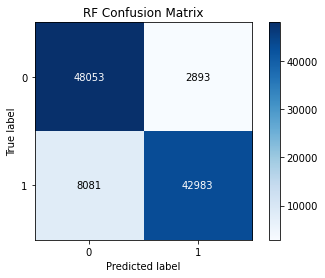

In [51]:
y_pred = rf_clf_model.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred))
print("ROC AUC: ", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.title('RF Confusion Matrix')
plt.savefig('graphs/rf_fs4/rf_confusion_matrix.png')

## XGBoost

In [53]:
xgb_param_grid = {
                    'n_estimators':[100, 200, 300], 
                    'max_depth': [4, 5, 6, 7, 8, 9, 10],
                    'learning_rate': [0.01, 0.1, 0.2, 0.27, 0.33]
                }

In [54]:
xgb_clf = xgb.XGBClassifier(
                    objective = "binary:logistic",
                    use_label_encoder=False,
                    eval_metric = "logloss",
                    booster = "gbtree",
                    tree_method = "hist",
                    grow_policy = "lossguide",
                )

In [56]:
xgb_clf_search = HalvingGridSearchCV(xgb_clf, xgb_param_grid, cv=splits, factor=2, scoring='accuracy', verbose=3)

In [57]:
xgb_clf_search.fit(X_train, y_train)

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 6375
max_resources_: 408038
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 105
n_resources: 6375
Fitting 1 folds for each of 105 candidates, totalling 105 fits


C:\Users\praab\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/1] END learning_rate=0.01, max_depth=4, n_estimators=100; total time=  10.4s


C:\Users\praab\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/1] END learning_rate=0.01, max_depth=4, n_estimators=200; total time=  18.9s


C:\Users\praab\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/1] END learning_rate=0.01, max_depth=4, n_estimators=300; total time=  27.6s


C:\Users\praab\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/1] END learning_rate=0.01, max_depth=5, n_estimators=100; total time=  16.5s


C:\Users\praab\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/1] END learning_rate=0.01, max_depth=5, n_estimators=200; total time=  32.4s


C:\Users\praab\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/1] END learning_rate=0.01, max_depth=5, n_estimators=300; total time=  47.1s


C:\Users\praab\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/1] END learning_rate=0.01, max_depth=6, n_estimators=100; total time=  25.5s


C:\Users\praab\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


KeyboardInterrupt: 

In [22]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import warnings

In [23]:
def objective(space):
    warnings.filterwarnings(action='ignore', category=UserWarning)
    classifier = xgb.XGBClassifier(
                    objective = "binary:logistic",
                    eval_metric = "logloss",
                    booster = "gbtree",
                    tree_method = "hist",
                    grow_policy = "lossguide",
                    n_estimators = 300, 
                    max_depth = space['max_depth'],
                    learning_rate = space['learning_rate'],
                )
    
    classifier.fit(X_train, y_train)
    
    predicted_probs = classifier.predict_proba(X_test)

    logloss = log_loss(y_test, predicted_probs)

    print("Log loss = " + str(logloss))

    return{'loss':logloss, 'status': STATUS_OK }

In [24]:
space = {
    'max_depth' : hp.choice('max_depth', range(4, 10, 1)),
    "learning_rate": hp.quniform("learning_rate", 0.01, 0.5, 0.01)
}

In [25]:
trials = Trials()
best_param = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=5,
            trials=trials)

  0%|                                                                            | 0/5 [06:01<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [64]:
print("Best Param : ", best_param)

Best Param :  {'learning_rate': 0.33, 'max_depth': 5}


#### Training the model with the tuned parameters.

In [65]:
params = dict(
            objective = "binary:logistic",
            eval_metric = "logloss",
            booster = "gbtree",
            tree_method = "hist",
            grow_policy = "lossguide",
            max_depth = 5,
            eta = 0.33
        )

In [58]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)

In [59]:
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [66]:
xgb_model = xgb.train(params, dtrain, 1000, watchlist, early_stopping_rounds=20, verbose_eval=10)

[0]	train-logloss:0.61066	valid-logloss:0.61116
[10]	train-logloss:0.49021	valid-logloss:0.49300
[20]	train-logloss:0.47613	valid-logloss:0.48028
[30]	train-logloss:0.46813	valid-logloss:0.47350
[40]	train-logloss:0.46272	valid-logloss:0.46936
[50]	train-logloss:0.45821	valid-logloss:0.46601
[60]	train-logloss:0.45449	valid-logloss:0.46342
[70]	train-logloss:0.45129	valid-logloss:0.46115
[80]	train-logloss:0.44839	valid-logloss:0.45945
[90]	train-logloss:0.44564	valid-logloss:0.45793
[100]	train-logloss:0.44313	valid-logloss:0.45641
[110]	train-logloss:0.44044	valid-logloss:0.45491
[120]	train-logloss:0.43779	valid-logloss:0.45308
[130]	train-logloss:0.43601	valid-logloss:0.45215
[140]	train-logloss:0.43401	valid-logloss:0.45132
[150]	train-logloss:0.43130	valid-logloss:0.45007
[160]	train-logloss:0.42882	valid-logloss:0.44868
[170]	train-logloss:0.42678	valid-logloss:0.44778
[180]	train-logloss:0.42467	valid-logloss:0.44676
[190]	train-logloss:0.42278	valid-logloss:0.44585
[200]	train

In [67]:
xgb_clf = xgb.XGBClassifier(
                    objective = "binary:logistic",
                    eval_metric = "logloss",
                    booster = "gbtree",
                    tree_method = "hist",
                    grow_policy = "lossguide",
                    n_estimators = 300, 
                    max_depth = '5',
                    learning_rate = '0.33',
                )
    
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, grow_policy='lossguide',
              importance_type='gain', interaction_constraints='',
              learning_rate='0.33', max_delta_step=0, max_depth='5',
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='hist', validate_parameters=1, verbosity=None)

### Evaluation

Log Loss:  0.43782111547161506
Accuracy:  0.7859327516910107
Precision:  0.7465373260227752
Recall:  0.8665791947360175
F1:  0.8020917354697795
ROC AUC:  0.785839355935904
              precision    recall  f1-score   support

           0       0.84      0.71      0.77     50946
           1       0.75      0.87      0.80     51064

    accuracy                           0.79    102010
   macro avg       0.79      0.79      0.78    102010
weighted avg       0.79      0.79      0.78    102010



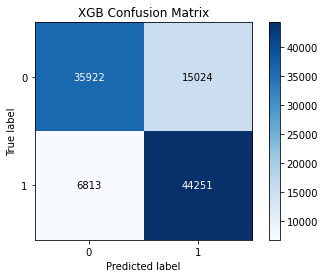

In [68]:
y_predicted_probs = xgb_clf.predict_proba(X_test)

y_pred = xgb_clf.predict(X_test)

print("Log Loss: ", log_loss(y_test, y_predicted_probs))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred))
print("ROC AUC: ", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.title('XGB Confusion Matrix')
plt.savefig('graphs/xgb_fs4/xgb_confusion_matrix.png')